In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess

In [2]:
# Load in our data
df = pd.read_csv('Channel_attribution.csv')

# Grab list of columns to iterate through
cols = df.columns

# Iterate through columns to change all ints to str and remove any trailing '.0'
for col in cols:
    df[col] = df[col].astype(str)
    df[col] = df[col].map(lambda x: str(x)[:-2] if '.' in x else str(x))

In [4]:
# Create a total path variable
df['Path'] = ''
for i in df.index:
    #df.at[i, 'Path'] = 'Start'
    for x in cols:
        df.at[i, 'Path'] = df.at[i, 'Path'] + df.at[i, x] + ' > '

In [10]:
# Split path on conversion (channel 21)
df['Path'] = df['Path'].map(lambda x: x.split(' > 21')[0])

# Create conversion value we can sum to get total conversions for each path
df['Conversion'] = 1

# Select relevant columns
df = df[['Path', 'Conversion']]

# Sum conversions by Path
df = df.groupby('Path').sum().reset_index()

# Write DF to CSV to be executed in R
df.to_csv('Paths.csv', index=False)

In [20]:
# Define the path to the R script that will run the Markov Model
path2script = 'C:/Users/User/Documents/python/Markov.r'

# Call the R script
# subprocess.call(['Rscript', '--vanilla', path2script], shell=True)

# Load in the CSV file with the model output from R
markov = pd.read_csv('Markov - Output - Conversion values.csv')

# # Select only the necessary columns and rename them
markov = markov[['channel_name', 'total_conversions']]
markov.columns = ['Channel', 'Conversion']

In [22]:
# First Touch Attribution
df['First Touch'] = df['Path'].map(lambda x: x.split(' > ')[0])
df_ft = pd.DataFrame()
df_ft['Channel'] = df['First Touch']
df_ft['Attribution'] = 'First Touch'
df_ft['Conversion'] = 1
df_ft = df_ft.groupby(['Channel', 'Attribution']).sum().reset_index()

# Last Touch Attribution
df['Last Touch'] = df['Path'].map(lambda x: x.split(' > ')[-1])
df_lt = pd.DataFrame()
df_lt['Channel'] = df['Last Touch']
df_lt['Attribution'] = 'Last Touch'
df_lt['Conversion'] = 1
df_lt = df_lt.groupby(['Channel', 'Attribution']).sum().reset_index()

# Linear Attribution
channel = []
conversion = []
for i in df.index:
    for j in df.at[i, 'Path'].split(' > '):
        channel.append(j)
        conversion.append(1/len(df.at[i, 'Path'].split(' > ')))
lin_att_df = pd.DataFrame()
lin_att_df['Channel'] = channel
lin_att_df['Attribution'] = 'Linear'
lin_att_df['Conversion'] = conversion
lin_att_df = lin_att_df.groupby(['Channel', 'Attribution']).sum().reset_index()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


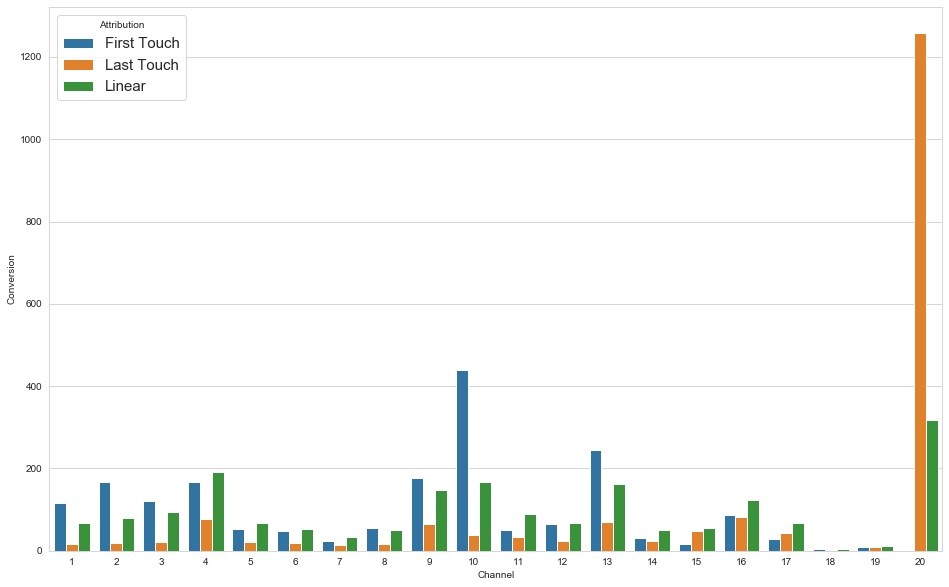

In [23]:
# Concatenate the four data frames to a single data frame
df_total_attr = pd.concat([df_ft, df_lt, lin_att_df, markov])
df_total_attr['Channel'] = df_total_attr['Channel'].astype(int)
df_total_attr.sort_values(by='Channel', ascending=True, inplace=True)


# Visualize the attributions
sns.set_style("whitegrid")
plt.rc('legend', fontsize=15)
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x='Channel', y='Conversion', hue='Attribution', data=df_total_attr)
plt.show()

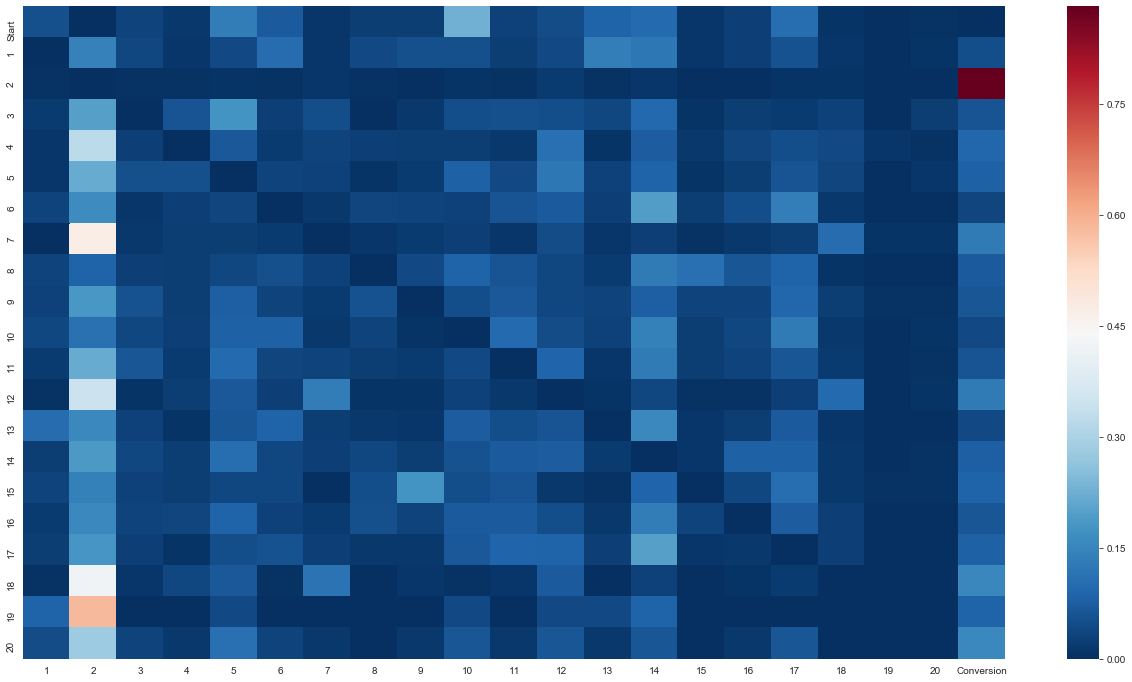

In [24]:
# Read in transition matrix CSV
trans_prob = pd.read_csv('Markov - Output - Transition matrix.csv')

# Convert data to floats
trans_prob ['transition_probability'] = trans_prob ['transition_probability'].astype(float)

# Convert start and conversion event to numeric values so we can sort and iterate through
trans_prob .replace('(start)', '0', inplace=True)
trans_prob .replace('(conversion)', '21', inplace=True)

# Get unique origin channels
channel_from_unique = trans_prob ['channel_from'].unique().tolist()
channel_from_unique.sort(key=float)

# Get unique destination channels
channel_to_unique = trans_prob ['channel_to'].unique().tolist()
channel_to_unique.sort(key=float)

# Create new matrix with origin and destination channels as columns and index
trans_matrix = pd.DataFrame(columns=channel_to_unique, index=channel_from_unique)

# Assign the probabilities to the corresponding cells in our transition matrix
for f in channel_from_unique:
    for t in channel_to_unique:
        x = trans_prob [(trans_prob ['channel_from'] == f) & (trans_prob ['channel_to'] == t)]
        prob = x['transition_probability'].values
        if prob.size > 0:
            trans_matrix[t][f] = prob[0]
        else:
            trans_matrix[t][f] = 0

# Convert all probabilities to floats
trans_matrix = trans_matrix.apply(pd.to_numeric)

# Rename our start and conversion events
trans_matrix.rename(index={'0': 'Start'}, inplace=True)
trans_matrix.rename(columns={'21': 'Conversion'}, inplace=True)

# Visualize this transition matrix in a heatmap
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(22, 12))
sns.heatmap(trans_matrix, cmap="RdBu_r")
plt.show()


In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict

df = pd.read_csv('attribution data.csv')
df = df.sort_values(['cookie', 'time'],
                    ascending=[False, True])
df['visit_order'] = df.groupby('cookie').cumcount() + 1

In [3]:
df_paths = df.groupby('cookie')['channel'].aggregate(
    lambda x: x.unique().tolist()).reset_index()
    
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')

df_paths['path'] = np.where(
    df_paths['conversion'] == 0,
    ['Start'] + df_paths['channel'] + ['Null'],
    ['Start'] + df_paths['channel'] + ['Conversion'])

df_paths = df_paths[['cookie', 'path']]

In [4]:
list_of_paths = df_paths['path']
total_conversions = sum(path.count('Conversion') for path in df_paths['path'].tolist())
base_conversion_rate = total_conversions / len(list_of_paths)

In [5]:
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states


trans_states = transition_states(list_of_paths)

In [7]:

def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


trans_prob = transition_prob(trans_states)

In [8]:
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

In [10]:

def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

In [11]:

def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, total_conversions)

In [12]:
attributions

{'Facebook': 4948.892177847523,
 'Online Video': 2886.4480895461475,
 'Instagram': 3031.521548555893,
 'Online Display': 2153.2469267590823,
 'Paid Search': 4618.891257291356}